# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Set a seed for reproducibility
seed_value = 41
np.random.seed(seed_value)

# Reality ODE
We will have 4 realities to test :
1. Reality 1: $\frac{u_\epsilon}{dt} = - u_\epsilon cos(2\pi \frac{t}{\epsilon})$ Identical to the assimilation Model.
1. Reality 2: $\frac{u_\epsilon}{dt} = - u_\epsilon cos(2\pi \frac{t}{\epsilon})+0.1sin(2\pi t)$ .
1. Reality 3: $\frac{u_\epsilon}{dt} = - \frac{u_\epsilon}{\sqrt{\epsilon}} cos(2\pi \frac{t}{\epsilon})$ Not homogenized yet .
1. Reality 4: $\frac{u_\epsilon}{dt} = - \frac{u_\epsilon}{\epsilon} cos(2\pi \frac{t}{\epsilon})$.
1. Reality 5: $\frac{u_\epsilon}{dt} = - u_\epsilon cos((2\pi+\epsilon cos(10t)) \frac{t}{\epsilon})$
# ODE Solution
The solutions to the previosuly mentioned problems are :
1. Reality 1: $u_\epsilon = e^{- \epsilon \frac{sin(2\pi \frac{t}{\epsilon})}{2 \pi}}$.
1. Reality 2: /.
1. Reality 3: $u_\epsilon= e^{\frac{-\sqrt{\epsilon}}{2\pi} sin(2 \pi \frac{t}{\epsilon})} \quad u_0(t)=1$.
1. Reality 4: $u_\epsilon= e^{\frac{-1}{2\pi} sin(2 \pi \frac{t}{\epsilon})} \quad u_0(t)=1$.




# Parameters
$\begin{cases}
\epsilon = 1/360\\
w = 60s\\
T = 15 hours\\
\Delta t=30minutes\\
\Delta t_\epsilon=10^{-3}seconds\\
h = \frac{10s}{\Delta t_\epsilon}\\
\mu_0,\sigma_0=0,0.01\\
\end{cases}$

## Reality 1


In [3]:
def ue1(t,eps):
    return 1.0- (eps*np.sin(2.0*np.pi*t/eps))/(2.0*np.pi)
def u01(t):
    return 1.0

## Reality 2

In [4]:
def ode2(x,t,eps):
    return -x*np.cos(2*np.pi*t/eps)+0.1*np.sin(2*np.pi*t)

## Reality 3 

In [5]:
def ue3(t,eps):
    return np.exp(- ((np.sqrt(eps)*np.sin(2.0*np.pi*t/eps))/(2.0*np.pi)))
def u03(t):
    return 1.0

## Reality 4

In [6]:
def ue4(t,eps):
    return np.exp(- ((np.sin(2.0*np.pi*t/eps))/(2.0*np.pi)))
def u04(t):
    return 1.0

# Data Generation

I begin by creating a dataframe containing the generated values across a period of 15 hours where the data is generated each 0.001 seconds meaning $\Delta t=0.001$ .

In [7]:
def genData(ue,u0,eps,h,step):
    v=[]
    for i in range(1,h*3600):
        for j in range(int(1/step)):
            v.append([i+step*j,u0(i+step*j),ue(i+step*j,eps)])

    arr= np.array(v)
    df = pd.DataFrame(arr)
    df.columns = ['X','Y0','Ye']
    return df

## Rolling average generator

In [8]:
#Data generator using moving averag for u0
def genDatawithMean(ue,window,eps,h,step):
    v=[]
    for i in range(1,h*3600+101):
        for j in range(int(1/step)):
            v.append([i+step*j,ue(i+step*j,eps)])

    arr= np.array(v)
    df = pd.DataFrame(arr)
    df.columns = ['X','Ye']
    df['Y0'] = df['Ye'].rolling(window=window*(int(1/step))).mean()
    return df

In [9]:
#Data generator using moving averag for u0
def genDatawithMeanODE(ue,x0,window,eps,h,step,l):
        # Initial condition
    t = np.linspace(0,h*3600,l)
    # Solve the ODE
    solution = odeint(ue, x0, t, args=(eps,))
    solution = solution.flatten()  # Flatten the solution array

    # Calculate the rolling average
    window_size = window  # Window size for rolling average
    rolling_avg = pd.Series(solution).rolling(window=window_size).mean().fillna(1)

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'X': t,
        'Ye': solution,
        'Y0': rolling_avg
    })

    return df

## Data Noising
This function adds Gaussian white noise to the macroscopic data $N(\mu,\sigma)$

In [10]:
def genNoiseData(df,gaussian_noise):
    # Add Gaussian noise to the 'y' column
    df['Y0']=df['Y0'].add(gaussian_noise) 

## Data Points
we take the macroscopic data at each half an hour  and the microscopic at each half an hour plus 10 seconds

In [11]:
def interval(df,macrostep,microstep):
    
    vals=[]
    # Define the interval in seconds (30 minutes)
    interval_seconds = macrostep * 60

    # Initialize the starting time
    current_time = 0

    while current_time < df['X'].max():

        # Find the index where 'X' is greater than or equal to the current_time
        index = df[df['X'] >= current_time].index[0]

        # Extract the 'Y' value at the current index
        current_y = df.at[index, 'Ye']

        # Extract the 'Z' value at the current index
        current_z = df.at[index, 'Y0']
        

        # Extract the next 100 values of 'Y' from the current index
        next_microsteps_y = df.loc[index:index + (microstep-1), 'Ye'].tolist()

        vals.append([current_z,next_microsteps_y])


        # Update the current time to the next interval
        current_time += interval_seconds
    vals = vals[1:]
    return vals

# JSON

In [12]:
def tojson(vals,name):
    file_path = name
    # Write the data to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(vals, json_file)

    print(f"Data has been saved to {file_path}")


# Plotting

In [2]:
def showfunction(df,x1,x2,title):
    plt.plot(df['X'], df['Ye'], label='Xɛ',color='red')
    plt.plot(df['X'], df['Y0'], label='X0')
    # Set axis labels and a title
    plt.title(title)
    # Set axis labels and a title
    plt.xlabel('Time (seconds)')
    plt.legend()
    plt.xlim(x1, x2)

    # Show the plot
    plt.show()

# Initialization

In [14]:
# Micro structure ratio
eps=1/360

# Number of Hours for generation
h=15

#time step
step=0.001

# Macroscopic noise
mu,sigma=0,0.01

#Macroscopic captured data step in minutes
macrostep=30

# Number of captured  microscopic steps in 10 seconds per macroscpic value
microstep=10/step

# Generation 

Data has been saved to GenData/True/Data_Model1
Data has been saved to GenData/True/Data_Model2
Data has been saved to GenData/True/Data_Model3
Data has been saved to GenData/True/Data_Model4


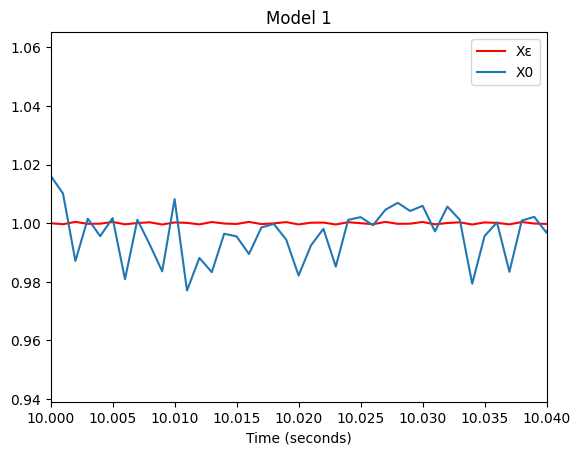

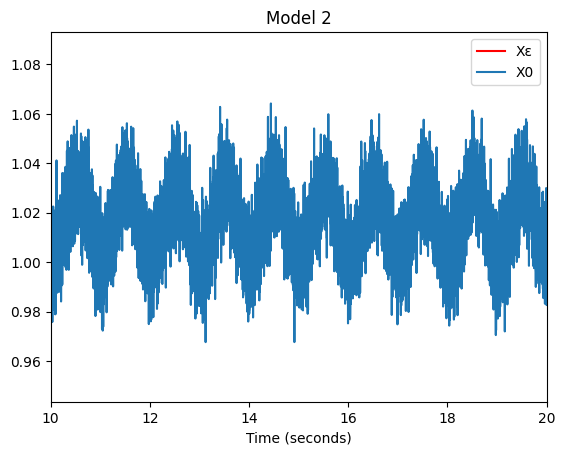

In [15]:

#window=1min
w=60

#Generating clean data
df1=genData(ue1,u01,eps,h,step)
#df2=genData(ue2,u02,eps,h,step)
df2=genDatawithMeanODE(ode2,1,60,eps,h,step,len(df1))
df3=genData(ue3,u03,eps,h,step)
df4=genData(ue4,u04,eps,h,step)

#Taking measurements
vals1=interval(df1,macrostep,microstep)
vals2=interval(df2,macrostep,microstep)
vals3=interval(df3,macrostep,microstep)
vals4=interval(df4,macrostep,microstep)

# Saving results in JSON
tojson(vals1,"GenData/True/Data_Model1")
tojson(vals2,"GenData/True/Data_Model2")
tojson(vals3,"GenData/True/Data_Model3")
tojson(vals4,"GenData/True/Data_Model4")

#Adding noise to data
gaussian_noise = np.random.normal(mu, sigma, len(df1))

df1_noised=df1.copy()
genNoiseData(df1_noised,gaussian_noise)
df2_noised=df2.copy()
genNoiseData(df2_noised,gaussian_noise)
df3_noised=df3.copy()
genNoiseData(df3_noised,gaussian_noise)
df4_noised=df4.copy()
genNoiseData(df4_noised,gaussian_noise)


showfunction(df1_noised,10,10.04,"Model 1")
showfunction(df2_noised,10,20,"Model 2")
showfunction(df3_noised,10,10.04,"Model 3")
showfunction(df4_noised,10,10.04,"Model 4")

#Taking measurements
vals1=interval(df1_noised,macrostep,microstep)
vals2=interval(df2_noised,macrostep,microstep)
vals3=interval(df3_noised,macrostep,microstep)
vals4=interval(df4_noised,macrostep,microstep)

# Saving results in JSON
tojson(vals1,"GenData/Noised/Data_Model1")
tojson(vals2,"GenData/Noised/Data_Model2")
tojson(vals3,"GenData/Noised/Data_Model3")
tojson(vals4,"GenData/Noised/Data_Model4")

In [35]:
print(len(df1))

53999000
